In [31]:
!pip install catboost


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
#import необходимых модулей
import pandas as pd
from itertools import groupby

from datetime import datetime, timedelta
import pandas as pd
import yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, r2_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as m
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from catboost import CatBoostClassifier,CatBoostRegressor, Pool
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [33]:
#Считывание данных в DataFrame 
train= pd.read_csv('train_out.csv', sep=';', index_col=None)
test=pd.read_csv('test_out.csv', sep=';', index_col=None)

In [34]:
train

Metka          dt  Цена на арматуру
0    меньше  01.12.2015             32500
1    меньше  01.19.2015             32000
2    меньше  01.26.2015             30700
3    меньше  02.02.2015             30300
4    меньше  02.09.2015             30300
..      ...         ...               ...
394  меньше  08.01.2022             47500
395  больше  08.08.2022             49000
396  меньше  08.15.2022             47500
397  меньше  08.22.2022             46500
398  меньше  08.29.2022             46000

[399 rows x 3 columns]

In [35]:
test

Цена на арматуру          dt
0              46000  09.05.2022
1              46000  09.12.2022
2              46000  09.19.2022
3              45500  09.26.2022
4              45500  10.03.2022
5              45000  10.10.2022
6              44000  10.17.2022
7              43000  10.24.2022
8              42000  10.31.2022
9              41500  11.07.2022
10             41000  11.14.2022
11             40000  11.21.2022
12             40000  11.28.2022
13             40500  12.05.2022
14             41700  12.12.2022
15             41700  12.19.2022
16             42500  12.26.2022
17             42700  01.02.2023
18             42700  01.09.2023
19             42700  01.16.2023
20             42800  01.23.2023
21             42800  01.30.2023
22             44500  02.06.2023
23             44500  02.13.2023
24             46000  02.20.2023
25             49200  02.27.2023
26             53700  03.06.2023
27             55500  03.13.2023

In [36]:
# Создание признаков по времени
train['Data_Time'] = pd.to_datetime(train.dt)
train['quarter'] = train['Data_Time'].dt.quarter
train['month'] = train['Data_Time'].dt.month
train['year'] = train['Data_Time'].dt.year
train['dayofyear'] = train['Data_Time'].dt.dayofyear
train['dayofmonth'] = train['Data_Time'].dt.day
train['weekofyear'] = train['Data_Time'].dt.isocalendar().week

test['Data_Time'] = pd.to_datetime(test.dt)
test['quarter'] = test['Data_Time'].dt.quarter
test['month'] = test['Data_Time'].dt.month
test['year'] = test['Data_Time'].dt.year
test['dayofyear'] = test['Data_Time'].dt.dayofyear
test['dayofmonth'] = test['Data_Time'].dt.day
test['weekofyear'] = test['Data_Time'].dt.isocalendar().week






In [37]:
# Делаем поля времени трейна и теста категориальными
for col in ['quarter',
       'month',  'weekofyear']:
    test[col] = test[col].astype('category')
    train[col] = train[col].astype('category')

In [38]:
train

Metka          dt  Цена на арматуру  Data_Time quarter month  year  \
0    меньше  01.12.2015             32500 2015-01-12       1     1  2015   
1    меньше  01.19.2015             32000 2015-01-19       1     1  2015   
2    меньше  01.26.2015             30700 2015-01-26       1     1  2015   
3    меньше  02.02.2015             30300 2015-02-02       1     2  2015   
4    меньше  02.09.2015             30300 2015-02-09       1     2  2015   
..      ...         ...               ...        ...     ...   ...   ...   
394  меньше  08.01.2022             47500 2022-08-01       3     8  2022   
395  больше  08.08.2022             49000 2022-08-08       3     8  2022   
396  меньше  08.15.2022             47500 2022-08-15       3     8  2022   
397  меньше  08.22.2022             46500 2022-08-22       3     8  2022   
398  меньше  08.29.2022             46000 2022-08-29       3     8  2022   

     dayofyear  dayofmonth weekofyear  
0           12          12          3  
1           19          19          4  
2           26          26          5  
3           33           2          6  
4           40           9          7  
..         ...         ...        ...  
394        213           1         31  
395        220           8         32  
396        227          15         33  
397        234          22         34  
398        241          29         35  

[399 rows x 10 columns]

In [39]:
# распределение бинарные признаков изменения тренда
train['Metka'].value_counts()

меньше    256
больше    143
Name: Metka, dtype: int64

In [40]:
train.columns

Index(['Metka', 'dt', 'Цена на арматуру', 'Data_Time', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [41]:
# набор признаков времени на вход
columns_to_train=['quarter',
       'month',  'year', 'dayofyear', 'dayofmonth', 'weekofyear']

In [42]:
# разбиение на вход и целевую переменную
x_train_all=train[columns_to_train]
y_train_all=train['Metka']

In [43]:
# Определяем веса классов тренда
classes = np.unique(y_train_all)
weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_train_all), y = np.ravel(y_train_all))
class_weights = dict(zip(classes, weights))
class_weights

{'больше': 1.3951048951048952, 'меньше': 0.779296875}

In [44]:
y_train_all

0      меньше
1      меньше
2      меньше
3      меньше
4      меньше
        ...  
394    меньше
395    больше
396    меньше
397    меньше
398    меньше
Name: Metka, Length: 399, dtype: object

In [45]:
# разбиение на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(\
    x_train_all, y_train_all, test_size = 0.15, random_state = 64,stratify=y_train_all)

In [46]:
x_train

quarter month  year  dayofyear  dayofmonth weekofyear
360       4    12  2021        340           6         49
287       3     7  2020        195          13         29
101       4    12  2016        354          19         51
359       4    11  2021        333          29         48
125       2     6  2017        156           5         23
..      ...   ...   ...        ...         ...        ...
74        2     6  2016        165          13         24
297       3     9  2020        265          21         39
346       3     8  2021        242          30         35
215       1     2  2019         56          25          9
258       4    12  2019        357          23         52

[339 rows x 6 columns]

In [47]:
y_train

360    меньше
287    больше
101    меньше
359    меньше
125    меньше
        ...  
74     меньше
297    больше
346    меньше
215    больше
258    больше
Name: Metka, Length: 339, dtype: object

In [48]:
x_train.dtypes

quarter       category
month         category
year             int64
dayofyear        int64
dayofmonth       int64
weekofyear    category
dtype: object

In [49]:
# создание пулов кэтбуст
pool_train_solution = Pool(x_train, y_train, cat_features = ['quarter',
       'month',  'weekofyear'])
pool_test_solution = Pool(x_test,y_test, cat_features = ['quarter',
       'month',  'weekofyear'])

In [50]:
# задание параметров модели
model_test = CatBoostClassifier(iterations=5000,bootstrap_type= 'MVS', task_type="CPU",learning_rate=0.015,class_weights={'больше': 1.1, 'меньше': 0.9},
                                loss_function='MultiClass',eval_metric='Accuracy',random_state=88)

In [51]:
# обучение
model_test.fit(pool_train_solution,eval_set=pool_test_solution,early_stopping_rounds=1500)

0:	learn: 0.5958093	test: 0.5856164	best: 0.5856164 (0)	total: 23.4ms	remaining: 1m 57s
1:	learn: 0.6182812	test: 0.5736301	best: 0.5856164 (0)	total: 54.9ms	remaining: 2m 17s
2:	learn: 0.6052232	test: 0.5736301	best: 0.5856164 (0)	total: 69.9ms	remaining: 1m 56s
3:	learn: 0.6261767	test: 0.5890411	best: 0.5890411 (3)	total: 102ms	remaining: 2m 6s
4:	learn: 0.6122077	test: 0.5736301	best: 0.5890411 (3)	total: 133ms	remaining: 2m 13s
5:	learn: 0.6091710	test: 0.5856164	best: 0.5890411 (3)	total: 162ms	remaining: 2m 15s
6:	learn: 0.6058305	test: 0.5856164	best: 0.5890411 (3)	total: 193ms	remaining: 2m 17s
7:	learn: 0.6024901	test: 0.5856164	best: 0.5890411 (3)	total: 221ms	remaining: 2m 18s
8:	learn: 0.5991497	test: 0.5856164	best: 0.5890411 (3)	total: 275ms	remaining: 2m 32s
9:	learn: 0.5991497	test: 0.5856164	best: 0.5890411 (3)	total: 334ms	remaining: 2m 46s
10:	learn: 0.5991497	test: 0.5856164	best: 0.5890411 (3)	total: 380ms	remaining: 2m 52s
11:	learn: 0.6058305	test: 0.5856164	bes

101:	learn: 0.6225326	test: 0.5856164	best: 0.5890411 (3)	total: 2.75s	remaining: 2m 11s
102:	learn: 0.6225326	test: 0.5856164	best: 0.5890411 (3)	total: 2.78s	remaining: 2m 12s
103:	learn: 0.6225326	test: 0.5856164	best: 0.5890411 (3)	total: 2.8s	remaining: 2m 12s
104:	learn: 0.6191922	test: 0.5856164	best: 0.5890411 (3)	total: 2.83s	remaining: 2m 11s
105:	learn: 0.6125114	test: 0.5856164	best: 0.5890411 (3)	total: 2.86s	remaining: 2m 11s
106:	learn: 0.6191922	test: 0.5856164	best: 0.5890411 (3)	total: 2.87s	remaining: 2m 11s
107:	learn: 0.6191922	test: 0.5856164	best: 0.5890411 (3)	total: 2.9s	remaining: 2m 11s
108:	learn: 0.6191922	test: 0.5856164	best: 0.5890411 (3)	total: 2.91s	remaining: 2m 10s
109:	learn: 0.6191922	test: 0.5856164	best: 0.5890411 (3)	total: 2.94s	remaining: 2m 10s
110:	learn: 0.6191922	test: 0.5856164	best: 0.5890411 (3)	total: 2.95s	remaining: 2m 9s
111:	learn: 0.6225326	test: 0.5856164	best: 0.5890411 (3)	total: 2.98s	remaining: 2m 10s
112:	learn: 0.6225326	te

200:	learn: 0.6811418	test: 0.5856164	best: 0.5890411 (3)	total: 5.44s	remaining: 2m 9s
201:	learn: 0.6811418	test: 0.5856164	best: 0.5890411 (3)	total: 5.47s	remaining: 2m 9s
202:	learn: 0.6844822	test: 0.5856164	best: 0.5890411 (3)	total: 5.49s	remaining: 2m 9s
203:	learn: 0.6878226	test: 0.5856164	best: 0.5890411 (3)	total: 5.52s	remaining: 2m 9s
204:	learn: 0.6878226	test: 0.5856164	best: 0.5890411 (3)	total: 5.55s	remaining: 2m 9s
205:	learn: 0.6911631	test: 0.5856164	best: 0.5890411 (3)	total: 5.58s	remaining: 2m 9s
206:	learn: 0.6911631	test: 0.5856164	best: 0.5890411 (3)	total: 5.61s	remaining: 2m 9s
207:	learn: 0.6911631	test: 0.5856164	best: 0.5890411 (3)	total: 5.62s	remaining: 2m 9s
208:	learn: 0.6911631	test: 0.5856164	best: 0.5890411 (3)	total: 5.66s	remaining: 2m 9s
209:	learn: 0.6878226	test: 0.5856164	best: 0.5890411 (3)	total: 5.67s	remaining: 2m 9s
210:	learn: 0.6878226	test: 0.5856164	best: 0.5890411 (3)	total: 5.71s	remaining: 2m 9s
211:	learn: 0.6844822	test: 0.58

298:	learn: 0.7385363	test: 0.5856164	best: 0.5890411 (3)	total: 8.39s	remaining: 2m 11s
299:	learn: 0.7385363	test: 0.5856164	best: 0.5890411 (3)	total: 8.4s	remaining: 2m 11s
300:	learn: 0.7385363	test: 0.5856164	best: 0.5890411 (3)	total: 8.43s	remaining: 2m 11s
301:	learn: 0.7385363	test: 0.5856164	best: 0.5890411 (3)	total: 8.45s	remaining: 2m 11s
302:	learn: 0.7385363	test: 0.6044520	best: 0.6044520 (302)	total: 8.48s	remaining: 2m 11s
303:	learn: 0.7385363	test: 0.5890411	best: 0.6044520 (302)	total: 8.51s	remaining: 2m 11s
304:	learn: 0.7452171	test: 0.5890411	best: 0.6044520 (302)	total: 8.54s	remaining: 2m 11s
305:	learn: 0.7452171	test: 0.5890411	best: 0.6044520 (302)	total: 8.56s	remaining: 2m 11s
306:	learn: 0.7452171	test: 0.5890411	best: 0.6044520 (302)	total: 8.59s	remaining: 2m 11s
307:	learn: 0.7418767	test: 0.5890411	best: 0.6044520 (302)	total: 8.62s	remaining: 2m 11s
308:	learn: 0.7418767	test: 0.5890411	best: 0.6044520 (302)	total: 8.64s	remaining: 2m 11s
309:	lea

389:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 11.1s	remaining: 2m 11s
390:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 11.1s	remaining: 2m 11s
391:	learn: 0.7819617	test: 0.5890411	best: 0.6044520 (302)	total: 11.2s	remaining: 2m 11s
392:	learn: 0.7786213	test: 0.5890411	best: 0.6044520 (302)	total: 11.2s	remaining: 2m 11s
393:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 11.2s	remaining: 2m 11s
394:	learn: 0.7786213	test: 0.5890411	best: 0.6044520 (302)	total: 11.3s	remaining: 2m 11s
395:	learn: 0.7752809	test: 0.5890411	best: 0.6044520 (302)	total: 11.3s	remaining: 2m 11s
396:	learn: 0.7819617	test: 0.5890411	best: 0.6044520 (302)	total: 11.4s	remaining: 2m 11s
397:	learn: 0.7819617	test: 0.5890411	best: 0.6044520 (302)	total: 11.4s	remaining: 2m 11s
398:	learn: 0.7853022	test: 0.5890411	best: 0.6044520 (302)	total: 11.4s	remaining: 2m 11s
399:	learn: 0.7819617	test: 0.5890411	best: 0.6044520 (302)	total: 11.5s	remaining: 2m 11s

481:	learn: 0.8059520	test: 0.5924657	best: 0.6078767 (458)	total: 14.3s	remaining: 2m 14s
482:	learn: 0.8092924	test: 0.5924657	best: 0.6078767 (458)	total: 14.3s	remaining: 2m 14s
483:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 14.4s	remaining: 2m 13s
484:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 14.4s	remaining: 2m 13s
485:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 14.4s	remaining: 2m 13s
486:	learn: 0.8059520	test: 0.5924657	best: 0.6078767 (458)	total: 14.4s	remaining: 2m 13s
487:	learn: 0.8092924	test: 0.5924657	best: 0.6078767 (458)	total: 14.5s	remaining: 2m 13s
488:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 14.5s	remaining: 2m 13s
489:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 14.5s	remaining: 2m 13s
490:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 14.6s	remaining: 2m 13s
491:	learn: 0.8126329	test: 0.5924657	best: 0.6078767 (458)	total: 14.6s	remaining: 2m 13s

578:	learn: 0.8460370	test: 0.6113014	best: 0.6113014 (578)	total: 17.2s	remaining: 2m 11s
579:	learn: 0.8460370	test: 0.6301370	best: 0.6301370 (579)	total: 17.3s	remaining: 2m 11s
580:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 17.3s	remaining: 2m 11s
581:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 17.3s	remaining: 2m 11s
582:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 17.4s	remaining: 2m 11s
583:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 17.4s	remaining: 2m 11s
584:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 17.4s	remaining: 2m 11s
585:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 17.4s	remaining: 2m 11s
586:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 17.5s	remaining: 2m 11s
587:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 17.5s	remaining: 2m 11s
588:	learn: 0.8493775	test: 0.6301370	best: 0.6301370 (579)	total: 17.5s	remaining: 2m 11s

676:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 20.1s	remaining: 2m 8s
677:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 20.2s	remaining: 2m 8s
678:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 20.2s	remaining: 2m 8s
679:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 20.2s	remaining: 2m 8s
680:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 20.3s	remaining: 2m 8s
681:	learn: 0.8888551	test: 0.6301370	best: 0.6301370 (579)	total: 20.3s	remaining: 2m 8s
682:	learn: 0.8888551	test: 0.6301370	best: 0.6301370 (579)	total: 20.3s	remaining: 2m 8s
683:	learn: 0.8888551	test: 0.6301370	best: 0.6301370 (579)	total: 20.3s	remaining: 2m 8s
684:	learn: 0.8888551	test: 0.6301370	best: 0.6301370 (579)	total: 20.4s	remaining: 2m 8s
685:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 20.4s	remaining: 2m 8s
686:	learn: 0.8855147	test: 0.6301370	best: 0.6301370 (579)	total: 20.4s	remaining: 2m 8s
687:	learn

774:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.1s	remaining: 2m 5s
775:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.1s	remaining: 2m 5s
776:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.3s	remaining: 2m 6s
777:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.3s	remaining: 2m 6s
778:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.3s	remaining: 2m 6s
779:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.4s	remaining: 2m 6s
780:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.4s	remaining: 2m 6s
781:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.4s	remaining: 2m 6s
782:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.5s	remaining: 2m 6s
783:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.5s	remaining: 2m 6s
784:	learn: 0.9088977	test: 0.5993151	best: 0.6301370 (579)	total: 23.5s	remaining: 2m 6s
785:	learn

870:	learn: 0.9222593	test: 0.6027397	best: 0.6301370 (579)	total: 26.2s	remaining: 2m 4s
871:	learn: 0.9222593	test: 0.5839041	best: 0.6301370 (579)	total: 26.3s	remaining: 2m 4s
872:	learn: 0.9222593	test: 0.5839041	best: 0.6301370 (579)	total: 26.3s	remaining: 2m 4s
873:	learn: 0.9222593	test: 0.5839041	best: 0.6301370 (579)	total: 26.3s	remaining: 2m 4s
874:	learn: 0.9222593	test: 0.6027397	best: 0.6301370 (579)	total: 26.3s	remaining: 2m 4s
875:	learn: 0.9255998	test: 0.6027397	best: 0.6301370 (579)	total: 26.4s	remaining: 2m 4s
876:	learn: 0.9255998	test: 0.6027397	best: 0.6301370 (579)	total: 26.4s	remaining: 2m 4s
877:	learn: 0.9289402	test: 0.6027397	best: 0.6301370 (579)	total: 26.4s	remaining: 2m 4s
878:	learn: 0.9289402	test: 0.6027397	best: 0.6301370 (579)	total: 26.5s	remaining: 2m 4s
879:	learn: 0.9289402	test: 0.6027397	best: 0.6301370 (579)	total: 26.5s	remaining: 2m 4s
880:	learn: 0.9289402	test: 0.6027397	best: 0.6301370 (579)	total: 26.5s	remaining: 2m 4s
881:	learn

962:	learn: 0.9383541	test: 0.6215753	best: 0.6301370 (579)	total: 29.1s	remaining: 2m 2s
963:	learn: 0.9383541	test: 0.6215753	best: 0.6301370 (579)	total: 29.1s	remaining: 2m 2s
964:	learn: 0.9383541	test: 0.6215753	best: 0.6301370 (579)	total: 29.2s	remaining: 2m 1s
965:	learn: 0.9383541	test: 0.6215753	best: 0.6301370 (579)	total: 29.2s	remaining: 2m 1s
966:	learn: 0.9383541	test: 0.6215753	best: 0.6301370 (579)	total: 29.2s	remaining: 2m 1s
967:	learn: 0.9383541	test: 0.6215753	best: 0.6301370 (579)	total: 29.3s	remaining: 2m 1s
968:	learn: 0.9416945	test: 0.6215753	best: 0.6301370 (579)	total: 29.3s	remaining: 2m 1s
969:	learn: 0.9416945	test: 0.6215753	best: 0.6301370 (579)	total: 29.3s	remaining: 2m 1s
970:	learn: 0.9416945	test: 0.6215753	best: 0.6301370 (579)	total: 29.3s	remaining: 2m 1s
971:	learn: 0.9416945	test: 0.6215753	best: 0.6301370 (579)	total: 29.4s	remaining: 2m 1s
972:	learn: 0.9416945	test: 0.6215753	best: 0.6301370 (579)	total: 29.4s	remaining: 2m 1s
973:	learn

1057:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32s	remaining: 1m 59s
1058:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.1s	remaining: 1m 59s
1059:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.1s	remaining: 1m 59s
1060:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.1s	remaining: 1m 59s
1061:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.2s	remaining: 1m 59s
1062:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.2s	remaining: 1m 59s
1063:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.2s	remaining: 1m 59s
1064:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.3s	remaining: 1m 59s
1065:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.3s	remaining: 1m 59s
1066:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.3s	remaining: 1m 59s
1067:	learn: 0.9517158	test: 0.6215753	best: 0.6301370 (579)	total: 32.3s	remainin

1150:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35s	remaining: 1m 57s
1151:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.1s	remaining: 1m 57s
1152:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.1s	remaining: 1m 57s
1153:	learn: 0.9583966	test: 0.6215753	best: 0.6301370 (579)	total: 35.1s	remaining: 1m 57s
1154:	learn: 0.9617370	test: 0.6215753	best: 0.6301370 (579)	total: 35.1s	remaining: 1m 57s
1155:	learn: 0.9617370	test: 0.6215753	best: 0.6301370 (579)	total: 35.2s	remaining: 1m 56s
1156:	learn: 0.9617370	test: 0.6215753	best: 0.6301370 (579)	total: 35.2s	remaining: 1m 56s
1157:	learn: 0.9617370	test: 0.6215753	best: 0.6301370 (579)	total: 35.2s	remaining: 1m 56s
1158:	learn: 0.9617370	test: 0.6215753	best: 0.6301370 (579)	total: 35.3s	remaining: 1m 56s
1159:	learn: 0.9617370	test: 0.6215753	best: 0.6301370 (579)	total: 35.3s	remaining: 1m 56s
1160:	learn: 0.9617370	test: 0.6215753	best: 0.6301370 (579)	total: 35.3s	remainin

1242:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 37.7s	remaining: 1m 54s
1243:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 37.8s	remaining: 1m 53s
1244:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 37.8s	remaining: 1m 53s
1245:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 37.8s	remaining: 1m 53s
1246:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 37.8s	remaining: 1m 53s
1247:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 37.9s	remaining: 1m 53s
1248:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 37.9s	remaining: 1m 53s
1249:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 37.9s	remaining: 1m 53s
1250:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38s	remaining: 1m 53s
1251:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38s	remaining: 1m 53s
1252:	learn: 0.9678105	test: 0.6215753	best: 0.6301370 (579)	total: 38s	remaining: 1

1334:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 40.4s	remaining: 1m 50s
1335:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 40.4s	remaining: 1m 50s
1336:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 40.5s	remaining: 1m 50s
1337:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 40.5s	remaining: 1m 50s
1338:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 40.5s	remaining: 1m 50s
1339:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 40.6s	remaining: 1m 50s
1340:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 40.6s	remaining: 1m 50s
1341:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 40.6s	remaining: 1m 50s
1342:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 40.6s	remaining: 1m 50s
1343:	learn: 0.9744913	test: 0.6215753	best: 0.6301370 (579)	total: 40.7s	remaining: 1m 50s
1344:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 40.7s	remain

1429:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.3s	remaining: 1m 48s
1430:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.4s	remaining: 1m 48s
1431:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.4s	remaining: 1m 48s
1432:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.4s	remaining: 1m 48s
1433:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.5s	remaining: 1m 48s
1434:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.5s	remaining: 1m 48s
1435:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.5s	remaining: 1m 47s
1436:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.5s	remaining: 1m 47s
1437:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.6s	remaining: 1m 47s
1438:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.6s	remaining: 1m 47s
1439:	learn: 0.9778318	test: 0.6215753	best: 0.6301370 (579)	total: 43.6s	remain

1524:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.1s	remaining: 1m 44s
1525:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.1s	remaining: 1m 44s
1526:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.1s	remaining: 1m 44s
1527:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.1s	remaining: 1m 44s
1528:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.2s	remaining: 1m 44s
1529:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.2s	remaining: 1m 44s
1530:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.2s	remaining: 1m 44s
1531:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.3s	remaining: 1m 44s
1532:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.3s	remaining: 1m 44s
1533:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 46.3s	remaining: 1m 44s
1534:	learn: 0.9778318	test: 0.6215753	best: 0.6404110 (1485)	total: 4

1618:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 49s	remaining: 1m 42s
1619:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 49s	remaining: 1m 42s
1620:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 49s	remaining: 1m 42s
1621:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 49.1s	remaining: 1m 42s
1622:	learn: 0.9805648	test: 0.6250000	best: 0.6404110 (1485)	total: 49.1s	remaining: 1m 42s
1623:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 49.1s	remaining: 1m 42s
1624:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 49.1s	remaining: 1m 42s
1625:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 49.2s	remaining: 1m 42s
1626:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 49.2s	remaining: 1m 42s
1627:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 49.2s	remaining: 1m 41s
1628:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 49.3s	r

1713:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 51.8s	remaining: 1m 39s
1714:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 51.9s	remaining: 1m 39s
1715:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 51.9s	remaining: 1m 39s
1716:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 51.9s	remaining: 1m 39s
1717:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 52s	remaining: 1m 39s
1718:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 52s	remaining: 1m 39s
1719:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 52.1s	remaining: 1m 39s
1720:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 52.1s	remaining: 1m 39s
1721:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 52.1s	remaining: 1m 39s
1722:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 52.1s	remaining: 1m 39s
1723:	learn: 0.9805648	test: 0.6215753	best: 0.6404110 (1485)	total: 52.2s

1808:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 55.1s	remaining: 1m 37s
1809:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 55.1s	remaining: 1m 37s
1810:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 55.2s	remaining: 1m 37s
1811:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 55.2s	remaining: 1m 37s
1812:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 55.3s	remaining: 1m 37s
1813:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 55.3s	remaining: 1m 37s
1814:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 55.3s	remaining: 1m 37s
1815:	learn: 0.9805648	test: 0.6061644	best: 0.6404110 (1485)	total: 55.4s	remaining: 1m 37s
1816:	learn: 0.9839053	test: 0.6061644	best: 0.6404110 (1485)	total: 55.4s	remaining: 1m 37s
1817:	learn: 0.9839053	test: 0.6061644	best: 0.6404110 (1485)	total: 55.4s	remaining: 1m 37s
1818:	learn: 0.9839053	test: 0.6061644	best: 0.6404110 (1485)	total: 5

1897:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 58.3s	remaining: 1m 35s
1898:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 58.3s	remaining: 1m 35s
1899:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 58.3s	remaining: 1m 35s
1900:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 58.4s	remaining: 1m 35s
1901:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 58.4s	remaining: 1m 35s
1902:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 58.4s	remaining: 1m 35s
1903:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 58.4s	remaining: 1m 35s
1904:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 58.5s	remaining: 1m 34s
1905:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 58.5s	remaining: 1m 34s
1906:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 58.5s	remaining: 1m 34s
1907:	learn: 0.9839053	test: 0.6404110	best: 0.6592466 (1883)	total: 5

1991:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 34s
1992:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 34s
1993:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 34s
1994:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 34s
1995:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 33s
1996:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 33s
1997:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 33s
1998:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 33s
1999:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 33s
2000:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 2s	remaining: 1m 33s
2001:	learn: 0.9839053	test: 0.6780822	best: 0.6934931 (1961)	total: 1

2085:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 32s
2086:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 32s
2087:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 32s
2088:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 32s
2089:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 32s
2090:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 32s
2091:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 32s
2092:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 32s
2093:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 32s
2094:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 6s	remaining: 1m 32s
2095:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1

2175:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 11s	remaining: 1m 32s
2176:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 11s	remaining: 1m 32s
2177:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 11s	remaining: 1m 32s
2178:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 11s	remaining: 1m 32s
2179:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 11s	remaining: 1m 32s
2180:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 11s	remaining: 1m 32s
2181:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 11s	remaining: 1m 32s
2182:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 11s	remaining: 1m 32s
2183:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 11s	remaining: 1m 32s
2184:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 11s	remaining: 1m 32s
2185:	learn: 0.9905861	test: 0.6780822	best: 0.6934931 (1961

2264:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961)	total: 1m 16s	remaining: 1m 32s
2265:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 32s
2266:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 32s
2267:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 32s
2268:	learn: 0.9933192	test: 0.6438356	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 32s
2269:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 32s
2270:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 32s
2271:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 32s
2272:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 32s
2273:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 17s	remaining: 1m 32s
2274:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961

2356:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 21s	remaining: 1m 31s
2357:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 21s	remaining: 1m 31s
2358:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 21s	remaining: 1m 31s
2359:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 21s	remaining: 1m 31s
2360:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 21s	remaining: 1m 31s
2361:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 21s	remaining: 1m 31s
2362:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 21s	remaining: 1m 31s
2363:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 22s	remaining: 1m 31s
2364:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 22s	remaining: 1m 31s
2365:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961)	total: 1m 22s	remaining: 1m 31s
2366:	learn: 0.9933192	test: 0.6780822	best: 0.6934931 (1961

2450:	learn: 0.9966596	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 26s	remaining: 1m 29s
2451:	learn: 0.9966596	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 26s	remaining: 1m 29s
2452:	learn: 0.9966596	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 26s	remaining: 1m 29s
2453:	learn: 0.9966596	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 26s	remaining: 1m 29s
2454:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 26s	remaining: 1m 29s
2455:	learn: 0.9966596	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 26s	remaining: 1m 29s
2456:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 26s	remaining: 1m 29s
2457:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 26s	remaining: 1m 29s
2458:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 26s	remaining: 1m 29s
2459:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 26s	remaining: 1m 29s
2460:	learn: 0.9933192	test: 0.6626712	best: 0.6934931 (1961

2541:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 29s	remaining: 1m 26s
2542:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 29s	remaining: 1m 26s
2543:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 29s	remaining: 1m 26s
2544:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 29s	remaining: 1m 26s
2545:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 29s	remaining: 1m 26s
2546:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 29s	remaining: 1m 26s
2547:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 29s	remaining: 1m 26s
2548:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 29s	remaining: 1m 26s
2549:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 29s	remaining: 1m 26s
2550:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 30s	remaining: 1m 26s
2551:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961

2632:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 24s
2633:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 23s
2634:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 23s
2635:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 23s
2636:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 23s
2637:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 23s
2638:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 23s
2639:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 23s
2640:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 23s
2641:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 33s	remaining: 1m 23s
2642:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961

2724:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 20s
2725:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 20s
2726:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 20s
2727:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 20s
2728:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 20s
2729:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 20s
2730:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 20s
2731:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 20s
2732:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 20s
2733:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 36s	remaining: 1m 20s
2734:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961

2817:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 16s
2818:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 16s
2819:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 16s
2820:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 16s
2821:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 16s
2822:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 16s
2823:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 16s
2824:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 16s
2825:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 16s
2826:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 39s	remaining: 1m 16s
2827:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961

2912:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 13s
2913:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 13s
2914:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 13s
2915:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 13s
2916:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 13s
2917:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 13s
2918:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 13s
2919:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 13s
2920:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 12s
2921:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 42s	remaining: 1m 12s
2922:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961

3003:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 10s
3004:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 10s
3005:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 9s
3006:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 9s
3007:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 9s
3008:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 9s
3009:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 9s
3010:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 9s
3011:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 9s
3012:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 45s	remaining: 1m 9s
3013:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total:

3094:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 1m 6s
3095:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 1m 6s
3096:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 1m 6s
3097:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 1m 6s
3098:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 1m 6s
3099:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 1m 6s
3100:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 1m 6s
3101:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 1m 6s
3102:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 1m 6s
3103:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 48s	remaining: 1m 6s
3104:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1

3187:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 1m 3s
3188:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 1m 3s
3189:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 1m 3s
3190:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 1m 3s
3191:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 1m 3s
3192:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 1m 3s
3193:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 1m 3s
3194:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 1m 3s
3195:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 1m 3s
3196:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 51s	remaining: 1m 3s
3197:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1

3280:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3281:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3282:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3283:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3284:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3285:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3286:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3287:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3288:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3289:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3290:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 56s	remaining: 1m
3291:	lear

3375:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 58s	remaining: 57.2s
3376:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 59s	remaining: 57.2s
3377:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 59s	remaining: 57.2s
3378:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 59s	remaining: 57.1s
3379:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 59s	remaining: 57.1s
3380:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 59s	remaining: 57.1s
3381:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 59s	remaining: 57s
3382:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 59s	remaining: 57s
3383:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 59s	remaining: 57s
3384:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 59s	remaining: 56.9s
3385:	learn: 1.0000000	test: 0.6626712	best: 0.6934931 (1961)	total: 1m 59s	

In [52]:
# оценка точности бинарной классификации
print(m.classification_report(y_test, model_test.predict(x_test), \
                            target_names = ['больше','меньше']))

              precision    recall  f1-score   support

      больше       0.69      0.41      0.51        22
      меньше       0.72      0.89      0.80        38

    accuracy                           0.72        60
   macro avg       0.71      0.65      0.66        60
weighted avg       0.71      0.72      0.70        60



In [53]:
x_test_all=test[columns_to_train]

In [54]:
# прогноз модели на тестовой выборке
model_test.predict(x_test_all)

array([['больше'],
       ['больше'],
       ['меньше'],
       ['меньше'],
       ['больше'],
       ['больше'],
       ['меньше'],
       ['больше'],
       ['меньше'],
       ['меньше'],
       ['меньше'],
       ['меньше'],
       ['меньше'],
       ['меньше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['меньше'],
       ['больше'],
       ['меньше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['больше'],
       ['больше']], dtype=object)

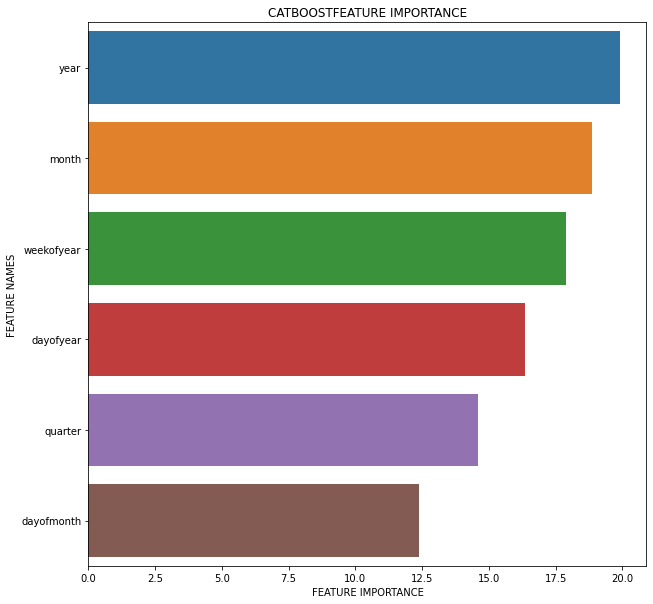

In [55]:
# Значимость признаков CatBoost в модели прогностики

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#plot the catboost result
plot_feature_importance(model_test.get_feature_importance(),x_train_all.columns,'CATBOOST')

In [56]:
# создание колонки прогнозов
test['Prognoz']=model_test.predict(x_test_all)

In [57]:
test

Цена на арматуру          dt  Data_Time quarter month  year  dayofyear  \
0              46000  09.05.2022 2022-09-05       3     9  2022        248   
1              46000  09.12.2022 2022-09-12       3     9  2022        255   
2              46000  09.19.2022 2022-09-19       3     9  2022        262   
3              45500  09.26.2022 2022-09-26       3     9  2022        269   
4              45500  10.03.2022 2022-10-03       4    10  2022        276   
5              45000  10.10.2022 2022-10-10       4    10  2022        283   
6              44000  10.17.2022 2022-10-17       4    10  2022        290   
7              43000  10.24.2022 2022-10-24       4    10  2022        297   
8              42000  10.31.2022 2022-10-31       4    10  2022        304   
9              41500  11.07.2022 2022-11-07       4    11  2022        311   
10             41000  11.14.2022 2022-11-14       4    11  2022        318   
11             40000  11.21.2022 2022-11-21       4    11  2022        325   
12             40000  11.28.2022 2022-11-28       4    11  2022        332   
13             40500  12.05.2022 2022-12-05       4    12  2022        339   
14             41700  12.12.2022 2022-12-12       4    12  2022        346   
15             41700  12.19.2022 2022-12-19       4    12  2022        353   
16             42500  12.26.2022 2022-12-26       4    12  2022        360   
17             42700  01.02.2023 2023-01-02       1     1  2023          2   
18             42700  01.09.2023 2023-01-09       1     1  2023          9   
19             42700  01.16.2023 2023-01-16       1     1  2023         16   
20             42800  01.23.2023 2023-01-23       1     1  2023         23   
21             42800  01.30.2023 2023-01-30       1     1  2023         30   
22             44500  02.06.2023 2023-02-06       1     2  2023         37   
23             44500  02.13.2023 2023-02-13       1     2  2023         44   
24             46000  02.20.2023 2023-02-20       1     2  2023         51   
25             49200  02.27.2023 2023-02-27       1     2  2023         58   
26             53700  03.06.2023 2023-03-06       1     3  2023         65   
27             55500  03.13.2023 2023-03-13       1     3  2023         72   

    dayofmonth weekofyear Prognoz  
0            5         36  больше  
1           12         37  больше  
2           19         38  меньше  
3           26         39  меньше  
4            3         40  больше  
5           10         41  больше  
6           17         42  меньше  
7           24         43  больше  
8           31         44  меньше  
9            7         45  меньше  
10          14         46  меньше  
11          21         47  меньше  
12          28         48  меньше  
13           5         49  меньше  
14          12         50  больше  
15          19         51  больше  
16          26         52  больше  
17           2          1  больше  
18           9          2  меньше  
19          16          3  больше  
20          23          4  меньше  
21          30          5  больше  
22           6          6  больше  
23          13          7  больше  
24          20          8  больше  
25          27          9  больше  
26           6         10  больше  
27          13         11  больше

In [58]:
# сохранение модели
model_test.save_model('catboost_model.bin')

In [59]:
# сохранение прогноза
test_itog=test[['dt','Цена на арматуру','Prognoz']]
test_itog.to_csv('Выполненный прогноз тренда.csv', sep=';', index=None)